In [ ]:
#Importing necessary Python Libraries.
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import ast
import pickle
from tqdm import tqdm
from scipy import sparse
from scipy.sparse import hstack
import statistics as st

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**USER DEFINED FUNCTIONS**

In [ ]:
#Function for creating age-buckets from age feature:

def age_buckets(feature):
  """
  Function that returns 0 for age group (19 - 39)
                        1 for age group (39 - 59)
                        2 for age group above 59
  """
  if feature >=19 and feature <=39:
    return 0
  elif feature >=40 and feature<=59:
    return 1
  else: 
    return 2

In [ ]:
#Function that converts string to a list:

def string_to_list(feature):
  
  """ Function that converts a string into a list """
  
  if (feature == ''):
    feature = ''
  elif (feature == 0.0):
    feature = 0.0
  else:
    feature = ast.literal_eval(feature)
  return feature

In [ ]:
#Functions for Creating New features in Sessions dataset - Action Summary Feature:

def action_summary(feature1,feature2):
  
  """ FUNCTION THAT TAKES ACTION AND SECS_ELAPSED AS INPUTS CORRESPONDING TO EACH USER AND 
      RETURNS A DICTIONARY WITH KEY AS THE ACTION SUBCATEGORIES AND 
      MEDIAN TIME SPENT BY USER IN PERFORMING THE ACTION SUBCATEGORY """
  
  if (feature1 == ''):
    return 0.0

  else:
    input_list = list(zip(feature1,feature2))
    dict_time = dict()  
    for feature,time in input_list:
        dict_time.setdefault(feature, []).append(time)
    for k,v in dict_time.items():
      dict_time[k] = st.median(v)
    return dict_time

In [ ]:
# Functions for processing old features in Sessions dataset:

def convert_tostring(lists):

  """ FUNCTION THAT CONVERTS A ELEMENTS IN A LIST INTO A STRING OF VALUES SEPARATED BY COMMA """

  _string = [str(i) for i in lists]
  _string = ','.join(lists)
  return _string

def total_time_secs(lists):

  """ FUNCTION THAT TAKES LIST OF TIME IN SECONDS VALUES AND SUM THEM UP"""
  if (lists == 0.0):
    time_secs = lists
  else:
    lists = [float(i) for i in lists]
    time_secs = sum(lists)
  return time_secs

In [ ]:
#Function that tokenizes string at comma ',':
def tokens(x):
        
    """  Function takes strings and tokenises using comma.    """
        
    return x.split(',')


#Loading the file that contains the fitted TF-IDF vectorizer:
vectorizer_tfidf=pickle.load(open('/content/drive/MyDrive/DataSets/vectorizer_tfidf','rb'))


#Storing the tf-idf feature names into a variable:
important_words = vectorizer_tfidf.get_feature_names()


#Removing the redundant words from the activity column and reframing the string with important actions:
def removing_redundant_words(feature):
  """
  Function that removes the redundant actions from the strings in activity column
  
  """
  if (len(feature)==0):
    feature = ''
  else:
    feature = feature.split(',')
    L = []
    for i in important_words:
      for k in feature:
        if (k==i):
          L.append(i)
    feature = ','.join(L)
  return feature

In [ ]:
#Functions for Creating New features in Sessions dataset - Useful Activity level:

def useful_activity_rating(feature1,feature2):
  """
  Function that returns useful activity level ie., (No.of Useful actions performed/Total number of actions performed)

  """
  x1 = len(feature1.split(','))
  if (feature2 == 0):
    return 0.000
  else:
    return np.round((x1/feature2),3)

**LOADING TRAINED MODELS**

In [9]:
#Loading the file that contains standardizer fitted on secs elapsed feature:
scaler_secs = pickle.load(open('/content/drive/MyDrive/DataSets/scaler_secs','rb'))

#Loading the file that contains standardizer fitted on time lag in seconds:
scaler_timelag = pickle.load(open('/content/drive/MyDrive/DataSets/scaler_timelag','rb'))

#Loading the file that contains Trained Logistic Regression with L1 Regularization Model:
lr_clf_l1_model = pickle.load(open('/content/drive/MyDrive/DataSets/LOGISTIC_REGRESSION_MODEL_L1','rb'))

#Loading the file that contains Trained Decision Tree Model:
dt_clf_model = pickle.load(open('/content/drive/MyDrive/DataSets/DECISION_TREE_MODEL','rb'))

#Loading the file that contains Trained Random Forest Model:
clf_rf_model = pickle.load(open('/content/drive/MyDrive/DataSets/RANDOM_FOREST_MODEL','rb'))

#Loading the file that contains Trained XG Boost Model:
xgb_model = pickle.load(open('/content/drive/MyDrive/DataSets/XGBOOST_MODEL','rb'))

#Loading the file that contains Label encoder fitted on country destination feature:
label_enc = pickle.load(open('/content/drive/MyDrive/DataSets/label_encoder','rb'))

**VALUES FROM THE TRAIN SET FOR TREATING NULL VALUES AND PROCESSING THE DATA IN TEST SET**

In [10]:
No_browsers= ['Yandex.Browser', 'SiteKiosk','IceWeasel', 'Iron','Pale Moon','CoolNovo','Opera Mini','wOSBrowser','SeaMonkey',\
              'TenFourFox','Mozilla','Googlebot','Outlook 2007','IceDragon','TheWorld Browser', 'RockMelt', 'Avant Browser']

age_median = 34

train_first_affiliate_tracked_mode = 'untracked'

features = ['gender_-unknown-','gender_FEMALE','gender_MALE','gender_OTHER','signup_method_basic','signup_method_facebook','signup_method_google',\
            'affiliate_channel_api','affiliate_channel_content','affiliate_channel_direct','affiliate_channel_other','affiliate_channel_remarketing',\
            'affiliate_channel_sem-brand','affiliate_channel_sem-non-brand','affiliate_channel_seo','affiliate_provider_baidu','affiliate_provider_bing',\
            'affiliate_provider_craigslist','affiliate_provider_daum','affiliate_provider_direct','affiliate_provider_email-marketing',\
            'affiliate_provider_facebook','affiliate_provider_facebook-open-graph','affiliate_provider_google','affiliate_provider_gsp',\
            'affiliate_provider_meetup','affiliate_provider_naver','affiliate_provider_other','affiliate_provider_padmapper','affiliate_provider_vast',\
            'affiliate_provider_wayn','affiliate_provider_yahoo','affiliate_provider_yandex','first_affiliate_tracked_linked','first_affiliate_tracked_local ops',\
            'first_affiliate_tracked_marketing','first_affiliate_tracked_omg','first_affiliate_tracked_product','first_affiliate_tracked_tracked-other',\
            'first_affiliate_tracked_untracked','signup_app_Android','signup_app_Moweb','signup_app_Web','signup_app_iOS','first_device_type_Android Phone',\
            'first_device_type_Android Tablet','first_device_type_Desktop (Other)','first_device_type_Mac Desktop','first_device_type_Other/Unknown',\
            'first_device_type_SmartPhone (Other)','first_device_type_Windows Desktop','first_device_type_iPad','first_device_type_iPhone','first_browser_-unknown-',\
            'first_browser_AOL Explorer','first_browser_Android Browser','first_browser_Apple Mail','first_browser_Arora','first_browser_BlackBerry Browser',\
            'first_browser_Camino','first_browser_Chrome','first_browser_Chrome Mobile','first_browser_Chromium','first_browser_CometBird',\
            'first_browser_Comodo Dragon','first_browser_Conkeror','first_browser_Crazy Browser','first_browser_Epic','first_browser_Firefox',\
            'first_browser_Flock','first_browser_Google Earth','first_browser_IE','first_browser_IE Mobile','first_browser_Kindle Browser','first_browser_Maxthon',\
            'first_browser_Mobile Firefox','first_browser_Mobile Safari','first_browser_NetNewsWire','first_browser_OmniWeb','first_browser_Opera',\
            'first_browser_Opera Mobile','first_browser_Others','first_browser_PS Vita browser','first_browser_Palm Pre web browser','first_browser_Safari',\
            'first_browser_Silk','first_browser_SlimBrowser','first_browser_Sogou Explorer','first_browser_Stainless']

**LOADING TEST AND PRE-PROCESSED SESSION DATASETS**

In [11]:
test_set = pd.read_csv('/content/drive/MyDrive/DataSets/test_users.csv.zip')
test_set.head(5)

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,5uwns89zht,2014-07-01,20140701000006,NaN,FEMALE,35.0,facebook,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
1,jtl0dijy2j,2014-07-01,20140701000051,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
2,xx0ulgorjt,2014-07-01,20140701000148,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome
3,6c6puo6ix0,2014-07-01,20140701000215,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,IE
4,czqhjk3yfe,2014-07-01,20140701000305,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Safari


In [12]:
sessions_dataset = pd.read_csv('/content/drive/MyDrive/DataSets/sessions_cleaned.csv')
sessions_dataset.head(5)

,user_id,secs_elapsed,activity
0,d1mm9tcy42,"[319.0, 67753.0, 301.0, 22141.0, 435.0, 7703.0...","['lookup_no_detail_no_type', 'search_results_v..."
1,yo8nz8bqcq,"[2739.0, 0.0, 115983.0, 20285.0, 3255.0, 47308...","['dashboard_dashboard_view', 'create_create_us..."
2,4grx6yxeby,"[65080.0, 0.0, 59801.0, 1000.0, 1624.0, 5134.0...","['verify_-unknown-_-unknown-', 'create_create_..."
3,ncf87guaf0,"[2204.0, 10834.0, 575.0, 578.0, 12407.0, 829.0...","['lookup_no_detail_no_type', 'show_p3_view', '..."
4,4rvqpxoh3h,"[375.0, 728.0, 0.0, 187.0, 154.0, 204.0, 21.0,...","['campaigns_-unknown-_-unknown-', 'active_-unk..."


In [13]:
session_ids = sessions_dataset.user_id.unique().tolist()

**FUNCTION THAT CONTAINS ENTIRE PIPELINE - RIGHT FROM PREPROCESSING TO FINDING OUTPUTS**

In [14]:
def final_model(X,model):

  X.drop(['date_first_booking','language'],inplace=True)
  
  if (X.first_browser in No_browsers):
    X.first_browser
  else:
    X.first_browser = 'Others'
  
  if ((X.age > 1900) & (X.age <2014)):
    X.age = 2014 - X.age
  elif ((X.age < 19) & (X.age >105)):
    X.age = age_median
  elif (math.isnan(X.age)):
    X.age = age_median
  
  if not (isinstance(X.first_affiliate_tracked,str)):
    X.first_affiliate_tracked = train_first_affiliate_tracked_mode
  
  X.date_account_created = pd.to_datetime(X.date_account_created)
  X.timestamp_first_active = pd.to_datetime(X.timestamp_first_active, format='%Y%m%d%H%M%S')

  month_account_created = X.date_account_created.month
  DayOfWeek_account_created = X.date_account_created.weekday()
  year_account_created = X.date_account_created.year
  time_lag = (X.timestamp_first_active - X.date_account_created).total_seconds()
  age_bucket = age_buckets(X.age)

  if (X.id in session_ids):
    ind = sessions_dataset[sessions_dataset.user_id == X.id].index[0]
    R = sessions_dataset.loc[ind]
    activity = string_to_list(R.activity)
    secs_elapsed = string_to_list(R.secs_elapsed)
  else:
    activity = ''
    secs_elapsed = 0.0
  
  test_action_summary = action_summary(activity,secs_elapsed)
  test_actions_count = len(activity)
  activity = removing_redundant_words(convert_tostring(activity))
  secs_elapsed = total_time_secs(secs_elapsed)
  test_session_useful_activity_rating = np.array(useful_activity_rating(activity,test_actions_count)).reshape(-1,1)
  test_session_age = np.array(X.age).reshape(-1,1)
  test_session_flow = np.array(X.signup_flow).reshape(-1,1)
  test_session_create_day = np.array(DayOfWeek_account_created).reshape(-1,1)
  test_session_create_month = np.array(month_account_created).reshape(-1,1)
  test_session_create_year = np.array(year_account_created).reshape(-1,1)
  test_session_age_bucket = np.array(age_bucket).reshape(-1,1)
  test_session_actions_count = np.array(test_actions_count).reshape(-1,1)
  
    
  ohe_list = ['gender', 'signup_method','affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked','signup_app','first_device_type', 'first_browser']
  ohe_df = pd.DataFrame(columns = features)
  ohe_df.loc[0] = np.zeros(len(features))
  for feature in ohe_list:
    V = pd.get_dummies(X[feature], prefix = feature).columns[0]
    if (V in features):
      ohe_df[pd.get_dummies(X[feature], prefix = feature).columns[0]] = 1.0
  
  
  test_vectorizer_tfidf = vectorizer_tfidf.transform([activity]).toarray()
  
  

  test_session_secs = scaler_secs.transform(np.array(secs_elapsed).reshape(-1,1))
  
  
  test_session_time_lag = scaler_timelag.transform(np.array(time_lag).reshape(-1,1))
    
  X_te = sparse.csr_matrix(np.hstack((ohe_df.to_numpy(),test_vectorizer_tfidf,test_session_secs,test_session_time_lag,test_session_age, test_session_flow,test_session_create_day,\
                                      test_session_create_month,test_session_create_year,test_session_useful_activity_rating,test_session_age_bucket,test_session_actions_count)))

  probabilities = model.predict_proba(X_te)

  for i in range(len(probabilities)):
    y_labels = label_enc.inverse_transform(np.argsort(probabilities[i])[::-1])[:5].tolist()
    

  return probabilities,y_labels  


**SCORING FUNCTION**

In [ ]:
#https://www.kaggle.com/davidgasquez/ndcg-scorer

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import make_scorer

def dcg_score(y_true, y_score, k=5):
    """ 
    Calculating Discounted cumulative gain (DCG) at rank K.

    """
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])

    gain = 2 ** y_true - 1

    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gain / discounts)


def ndcg_score(te_labels, predict, k):       
    """
    Calculating Normalized discounted cumulative gain (NDCG) at rank K.
  
    """
 
    lb = LabelBinarizer()
    lb.fit(range(len(predict[0][0]) + 1))
    T = lb.transform(te_labels)
    
    scores = []

    # Iterate over each y_true and compute the DCG score
    for y_true, y_score in zip(T, predict):
        actual = dcg_score(y_true, y_score, k)
        best = dcg_score(y_true, y_true, k)
        if best == 0:
            best = 0.000000001
        score = float(actual) / float(best)
        scores.append(score)
    
    return np.mean(scores)

# NDCG Scorer function
ndcg_scorer = make_scorer(ndcg_score, needs_proba=True, k=5)

#**RESULTS:**

**RESULTS FROM XG BOOST**

In [ ]:
from tqdm import tqdm
ids = []
countries = []
y_list = []

for i in tqdm(range(0,len(test_set))):
  X = test_set.loc[i]
  proba,countries_i = final_model(X,xgb_model)
  ids += [X.id]*5
  countries += countries_i

100%|██████████| 62096/62096 [48:58<00:00, 21.13it/s]


In [ ]:
#Loading results from XG Boost model into a DataFrame.
output = pd.DataFrame(list(zip(ids,countries)),columns = ['id','country'])
output.head(10)

,id,country
0,5uwns89zht,NDF
1,5uwns89zht,US
2,5uwns89zht,other
3,5uwns89zht,FR
4,5uwns89zht,IT
5,jtl0dijy2j,NDF
6,jtl0dijy2j,US
7,jtl0dijy2j,other
8,jtl0dijy2j,FR
9,jtl0dijy2j,IT


In [ ]:
#Dumping the dataFrame into a CSV file for submission.
output.to_csv('/content/drive/MyDrive/DataSets/XG_Boost_output.csv',index=False)

**RESULTS ON KAGGLE SUBMISSION**

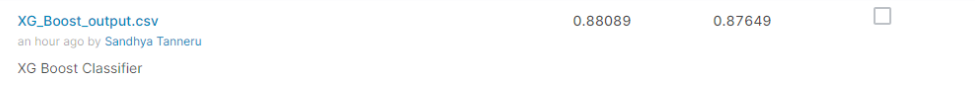

**RESULTS FROM RANDOM FOREST**

In [ ]:
from tqdm import tqdm
ids = []
countries = []

for i in tqdm(range(0,len(test_set))):
  X = test_set.loc[i]
  proba,countries_i = final_model(X,clf_rf_model)
  ids += [X.id]*5
  countries += countries_i

100%|██████████| 62096/62096 [2:30:11<00:00,  6.89it/s]


In [ ]:
#Loading results from Random forest into a DataFrame.
output = pd.DataFrame(list(zip(ids,countries)),columns = ['id','country'])
output.head(10)

,id,country
0,5uwns89zht,NDF
1,5uwns89zht,US
2,5uwns89zht,other
3,5uwns89zht,FR
4,5uwns89zht,IT
5,jtl0dijy2j,NDF
6,jtl0dijy2j,US
7,jtl0dijy2j,other
8,jtl0dijy2j,FR
9,jtl0dijy2j,IT


In [ ]:
#Dumping the dataFrame into a CSV file for submission.
output.to_csv('/content/drive/MyDrive/DataSets/Random_Forest_output.csv',index=False)

**RESULT ON KAGGLE SUBMISSION**

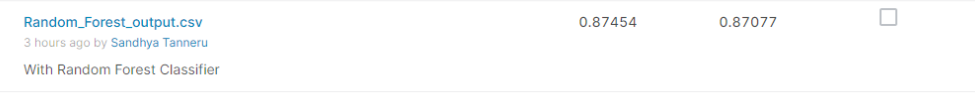

**RESULTS FROM DECISION TREE**

In [ ]:
from tqdm import tqdm
ids = []
countries = []

for i in tqdm(range(0,len(test_set))):
  X = test_set.loc[i]
  proba,countries_i = final_model(X,dt_clf_model)
  ids += [X.id]*5
  countries += countries_i

100%|██████████| 62096/62096 [40:42<00:00, 25.42it/s]


In [ ]:
#Loading results from Decision Tree into a DataFrame.
output = pd.DataFrame(list(zip(ids,countries)),columns = ['id','country'])
output.head(10)

,id,country
0,5uwns89zht,NDF
1,5uwns89zht,US
2,5uwns89zht,other
3,5uwns89zht,FR
4,5uwns89zht,ES
5,jtl0dijy2j,NDF
6,jtl0dijy2j,US
7,jtl0dijy2j,other
8,jtl0dijy2j,FR
9,jtl0dijy2j,IT


In [ ]:
#Dumping the dataFrame into a CSV file for submission.
output.to_csv('/content/drive/MyDrive/DataSets/Decision_Tree_output.csv',index=False)

**RESULT BASED ON KAGGLE SUBMISSION**

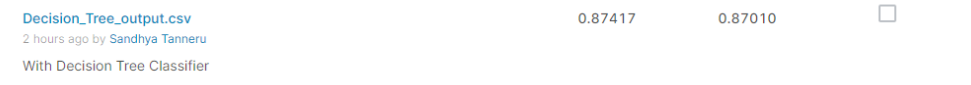

**RESULTS FROM LOGISTIC REGRESSION WITH L1 REG**

In [15]:
from tqdm import tqdm
ids = []
countries = []

for i in tqdm(range(0,len(test_set))):
  X = test_set.loc[i]
  proba,countries_i = final_model(X,lr_clf_l1_model)
  ids += [X.id]*5
  countries += countries_i

100%|██████████| 62096/62096 [37:37<00:00, 27.50it/s]


In [16]:
#Loading results from Logistic Regression model into a DataFrame.
output = pd.DataFrame(list(zip(ids,countries)),columns = ['id','country'])
output.head(10)

,id,country
0,5uwns89zht,NDF
1,5uwns89zht,US
2,5uwns89zht,other
3,5uwns89zht,FR
4,5uwns89zht,IT
5,jtl0dijy2j,NDF
6,jtl0dijy2j,US
7,jtl0dijy2j,other
8,jtl0dijy2j,FR
9,jtl0dijy2j,IT


In [17]:
#Dumping the dataFrame into a CSV file for submission.
output.to_csv('/content/drive/MyDrive/DataSets/Logistic_regression_L1_output.csv',index=False)

**RESULT ON KAGGLE SUBMISSION**

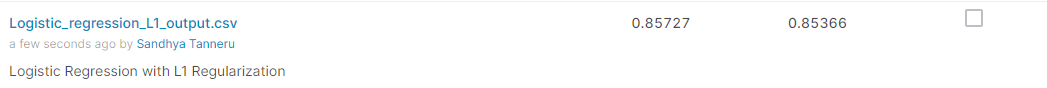

In [18]:
#Results summary:

from prettytable import PrettyTable
PT = PrettyTable()
PT.field_names = ["Model", "NDCG Score from Kaggle"]
PT.add_row(["XG Boost Model","0.88089"])
PT.add_row(["Random Forest Model","0.87454"])
PT.add_row(["Decision tree Model","0.87417"])
PT.add_row(["Logistic Regression (L1 Penalty)","0.85727"])
print(PT)

+----------------------------------+------------------------+
|              Model               | NDCG Score from Kaggle |
+----------------------------------+------------------------+
|          XG Boost Model          |        0.88089         |
|       Random Forest Model        |        0.87454         |
|       Decision tree Model        |        0.87417         |
| Logistic Regression (L1 Penalty) |        0.85727         |
+----------------------------------+------------------------+
